In [18]:
from utils import *

In [136]:
import pickle
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import random

In [364]:
with open( "train_test_data.pkl", "rb") as f:
    X_train, y_train, X_test, y_test = pickle.load(f)

In [98]:
X_train = pd.DataFrame(X_train.values(),index = X_train.keys()) # convert from dict to pd DataFrame
X_train['tracks'] = X_train.values.tolist() #stack all columns into one
X_train = X_train[['tracks']]

In [365]:
X_test = pd.DataFrame(X_test.values(),index = X_test.keys()) # convert from dict to pd DataFrame
X_test['tracks'] = X_test.values.tolist() #stack all columns into one
X_test = X_test[['tracks']]

In [ ]:
# create one hot encoding for all the tracks
X_train_onehot = pd.get_dummies(pd.DataFrame(X_train['tracks'].values.tolist()), prefix='', prefix_sep='').groupby(axis=1, level=0).max()
X_train_onehot = X_train_onehot.set_index(X_train.index)
X_train_onehot.shape #7473 101217

In [366]:
# create one hot encoding for all the tracks
X_test_onehot = pd.get_dummies(pd.DataFrame(X_test['tracks'].values.tolist()), prefix='', prefix_sep='').groupby(axis=1, level=0).max()
X_test_onehot = X_test_onehot.set_index(X_test.index)
X_test_onehot.shape #7473 101217

(2525, 47521)

In [6]:
tracks = list(X_train_onehot.columns) #all the tracks appear in the X_train

In [7]:
track_playlist_data = csr_matrix(X_train_onehot) #prepare the data matrix for the implicit package

In [367]:
track_playlist_data_test = csr_matrix(X_test_onehot)

In [90]:
X_train.head()

,tracks
323_381,"[spotify:track:6WhzFzROw3aq3rPWjgYlxr, spotify..."
323_507,"[spotify:track:7DD1ojeTUwnW65g5QuZw7X, spotify..."
323_543,"[spotify:track:61LtVmmkGr8P9I2tSPvdpf, spotify..."
323_570,"[spotify:track:0r9knJtQ6VVpX324mtkLcX, spotify..."
323_682,"[spotify:track:5vIu19A3EEdHgFM4Cba6F4, spotify..."


In [94]:
track_playlist_data.shape[0]

7473

In [ ]:
def intersect_rate(lst1, lst2): 
        return len(list(set(lst1) & set(lst2))) 

In [270]:
def score(estimator,X,y):
    def intersect_rate(lst1, lst2): 
        return len(list(set(lst1) & set(lst2))) 
    acc = 0
    acc_ind = []
    for ind in range(X.shape[0]):
        playlistid = ind
        # recommend 10(default) tracks for a playlist
        playlist_track = X.T
        recommendations = estimator.recommend(playlistid, playlist_track)
        playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
        playlist_true = [j for j in y[playlistid] if j is not None]
        acc_ind.append(intersect_rate(playlist_true,playlist_pred))
    return np.mean(acc_ind)

In [349]:
facts = range(1,50, 10)
iters = range(2,20,4)

In [350]:
print(len(facts))
print(len(iters))

5
5


In [357]:
#create cv index
cv = 2
l = X_train.shape[0]
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, l, l//n):
        # Create an index range for l of n items:
        linspace = np.linspace(i,i+(l//n),(l//n))
        index = [int(j) for j in list(linspace)]
        yield index     
train_cv_ind = list(chunks(l,cv))

In [358]:
ind = [i for i in range(cv) if i != 0]
print(ind)
np.concatenate([train_cv_ind[i] for i in ind] )

[1]


array([3736, 3737, 3738, ..., 7469, 7470, 7472])

In [289]:
acc_val_fact = np.zeros(5)
acc_train_fact = np.zeros(5)
i = 0
for fac in facts:
    acc_val_fac = []
    acc_train_fac = []
    for cv_ind in range(cv):
        ind = [j for j in range(cv) if j != cv_ind]
        total_ind = np.concatenate([train_cv_ind[k] for k in ind] )
        X = track_playlist_data[total_ind]
        y = X_train.tracks[total_ind]
        X_test = track_playlist_data[train_cv_ind[cv_ind]]
        y_test = X_train.tracks[train_cv_ind[cv_ind]]
        model = implicit.als.AlternatingLeastSquares(factors = fac,iterations = 11)
        model.fit(X.T)
        acc_val_fac.append(score(model,X_test,y_test))
        acc_train_fac.append(score(model,X,y))
    acc_val_fact[i] = np.mean(acc_val_fac)
    acc_train_fact[i] = np.mean(acc_train_fac)
    print(acc_train_fact)
    print(acc_val_fact)
    i = i + 1     


[0.79068522 0.         0.         0.         0.        ]
[0.16956638 0.         0.         0.         0.        ]



[0.79068522 2.00963597 0.         0.         0.        ]
[0.16956638 0.12607066 0.         0.         0.        ]



[0.79068522 2.00963597 2.73942719 0.         0.        ]
[0.16956638 0.12607066 0.11041221 0.         0.        ]



[0.79068522 2.00963597 2.73942719 3.30902034 0.        ]
[0.16956638 0.12607066 0.11041221 0.10505889 0.        ]



[0.79068522 2.00963597 2.73942719 3.30902034 3.75950214]
[0.16956638 0.12607066 0.11041221 0.10505889 0.10037473]


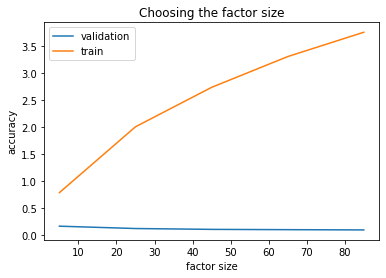

In [291]:
plt.plot(np.arange(5,105, 20),acc_val, label = 'validation')
plt.plot(np.arange(5,105, 20),acc_train, label = 'train')
plt.xlabel('factor size')
plt.ylabel('accuracy')
plt.title('Choosing the factor size')
plt.legend()
plt.show()

In [351]:
acc_val_iter = np.zeros(5)
acc_train_iter = np.zeros(5)
i = 0
for it in iters:
    acc_val_it = []
    acc_train_it = []
    for cv_ind in range(cv):
        ind = [j for j in range(cv) if j != cv_ind]
        total_ind = np.concatenate([train_cv_ind[k] for k in ind] )
        X = track_playlist_data[total_ind]
        y = X_train.tracks[total_ind]
        X_test = track_playlist_data[train_cv_ind[cv_ind]]
        y_test = X_train.tracks[train_cv_ind[cv_ind]]
        model = implicit.als.AlternatingLeastSquares(factors = 1,iterations = it)
        model.fit(X.T)
        acc_val_it.append(score(model,X_test,y_test))
        acc_train_it.append(score(model,X,y))
    acc_val_iter[i] = np.mean(acc_val_it)
    acc_train_iter[i] = np.mean(acc_train_it)
    print(acc_val_iter)
    print(acc_train_iter)
    i = i + 1     


[0.23434154 0.         0.         0.         0.        ]
[0.24986617 0.         0.         0.         0.        ]



[0.23434154 0.23273555 0.         0.         0.        ]
[0.24986617 0.24397752 0.         0.         0.        ]



[0.23434154 0.23273555 0.23112955 0.         0.        ]
[0.24986617 0.24397752 0.24504818 0.         0.        ]



[0.23434154 0.23273555 0.23112955 0.23112955 0.        ]
[0.24986617 0.24397752 0.24504818 0.24504818 0.        ]



[0.23434154 0.23273555 0.23112955 0.23112955 0.23112955]
[0.24986617 0.24397752 0.24504818 0.24504818 0.24504818]


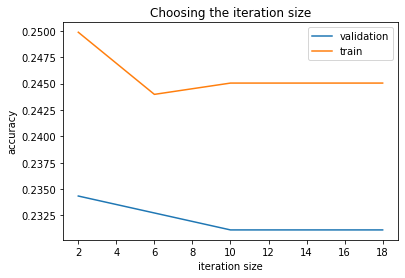

In [352]:
plt.plot(np.arange(2,20,4),acc_val_iter, label = 'validation')
plt.plot(np.arange(2,20,4),acc_train_iter, label = 'train')
plt.xlabel('iteration size')
plt.ylabel('accuracy')
plt.title('Choosing the iteration size')
plt.legend()
plt.show()


In [354]:
## after trying cv on factor size from 1-40, iteraotion size 1-20, factor size of 1 seems to be the best; so we do 5-fold cv
## on iteration size too
cv = 5
l = X_train.shape[0]
def chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, l, l//n):
        # Create an index range for l of n items:
        linspace = np.linspace(i,i+(l//n),(l//n))
        index = [int(j) for j in list(linspace)]
        yield index     
train_cv_ind = list(chunks(l,cv))

acc_val_iter = np.zeros(3)
acc_train_iter = np.zeros(3)
i = 0
iters = range(1,4)
for it in iters:
    acc_val_it = []
    acc_train_it = []
    for cv_ind in range(cv):
        ind = [j for j in range(cv) if j != cv_ind]
        total_ind = np.concatenate([train_cv_ind[k] for k in ind] )
        X = track_playlist_data[total_ind]
        y = X_train.tracks[total_ind]
        X_test = track_playlist_data[train_cv_ind[cv_ind]]
        y_test = X_train.tracks[train_cv_ind[cv_ind]]
        model = implicit.als.AlternatingLeastSquares(factors = 1,iterations = it)
        model.fit(X.T)
        acc_val_it.append(score(model,X_test,y_test))
        acc_train_it.append(score(model,X,y))
    acc_val_iter[i] = np.mean(acc_val_it)
    acc_train_iter[i] = np.mean(acc_train_it)
    print(acc_val_iter)
    print(acc_train_iter)
    i = i + 1  


[0.23868809 0.         0.        ]
[0.24688755 0.         0.        ]



[0.23868809 0.23908969 0.        ]
[0.24688755 0.24628514 0.        ]


KeyboardInterrupt: 

In [359]:
acc_val_reg = np.zeros(3)
acc_train_reg = np.zeros(3)
i = 0
for reg in [0,0.01,0.1]:
    acc_val_it = []
    acc_train_it = []
    for cv_ind in range(cv):
        ind = [j for j in range(cv) if j != cv_ind]
        total_ind = np.concatenate([train_cv_ind[k] for k in ind] )
        X = track_playlist_data[total_ind]
        y = X_train.tracks[total_ind]
        X_test = track_playlist_data[train_cv_ind[cv_ind]]
        y_test = X_train.tracks[train_cv_ind[cv_ind]]
        model = implicit.als.AlternatingLeastSquares(factors = 5,iterations = 5, regularization = reg)
        model.fit(X.T)
        acc_val_it.append(score(model,X_test,y_test))
        acc_train_it.append(score(model,X,y))
    acc_val_reg[i] = np.mean(acc_val_it)
    acc_train_reg[i] = np.mean(acc_train_it)
    print(acc_val_reg)
    print(acc_train_reg)
    i = i + 1     


[0.1643469 0.        0.       ]
[0.82963062 0.         0.        ]



[0.1643469  0.16675589 0.        ]
[0.82963062 0.81116167 0.        ]



[0.1643469  0.16675589 0.16662206]
[0.82963062 0.81116167 0.82855996]


In [389]:
model = implicit.als.AlternatingLeastSquares(factors=1, iterations = 1)

# train the model on a sparse matrix of item/user/confidence weights
model.fit(track_playlist_data.T)

acc = 0
acc_ind = []
for ind in range(len(X_test)):
    playlistid = ind
    # recommend 10(default) tracks for a playlist
    playlist_track = track_playlist_data_test.T
    recommendations = model.recommend(playlistid, playlist_track)
    playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0]]
    playlist_true = [j for j in X_test.tracks[playlistid] if j is not None]
    acc_ind.append(intersect_rate(playlist_true,playlist_pred))
print('Overall test accuracy of ALS: ', np.mean(acc_ind))


Overall test accuracy of ALS:  0.23683168316831682


In [83]:
# no cv version of choosing factor size
acc_mean = np.zeros(10)
i = 0
for fac in np.arange(0,100,10):
    # initialize a model
    model = implicit.als.AlternatingLeastSquares(factors=fac)

    # train the model on a sparse matrix of item/user/confidence weights
    model.fit(track_playlist_data.T)

    acc = 0
    acc_ind = []
    for ind in range(7473):
        playlistid = ind
        # recommend 10(default) tracks for a playlist
        playlist_track = track_playlist_data.tocsr()
        recommendations = model.recommend(playlistid, playlist_track)
        playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
        playlist_true = [j for j in X_train.tracks[ind] if j is not None]
        acc_ind.append(intersect_rate(playlist_true,playlist_pred))
    acc_mean[i] = np.mean(acc_ind)
    print(acc_mean[i])
    i = i + 1


KeyboardInterrupt: 

In [84]:
# no cv version of choosing iteration size
acc_mean = np.zeros(10)
i = 0
for it in np.arange(0,100,10):
    # initialize a model
    model = implicit.als.AlternatingLeastSquares(factors=10, iterations = it)
    
    # train the model on a sparse matrix of item/user/confidence weights
    model.fit(track_playlist_data.T)

    acc = 0
    acc_ind = []
    for ind in range(7473):
        playlistid = ind
        # recommend 10(default) tracks for a playlist
        playlist_track = track_playlist_data.tocsr()
        recommendations = model.recommend(playlistid, playlist_track)
        playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
        playlist_true = [j for j in X_train.tracks[ind] if j is not None]
        acc_ind.append(intersect_rate(playlist_true,playlist_pred))
    acc_mean[i] = np.mean(acc_ind)
    print(acc_mean[i])
    i = i + 1


KeyboardInterrupt: 

# -------END---------- 辛苦了！

In [54]:
from implicit.lmf import LogisticMatrixFactorization

In [327]:
# choosing facts, fact should be smaller than 4
iters = range(1,20,4)
facts = range(1,50,10)
acc_val_iter_log = {}
acc_train_iter_log = {}

for fac in facts:
    for it in iters:
        acc_val_it = []
        acc_train_it = []
        for cv_ind in range(cv):
            ind = [j for j in range(cv) if j != cv_ind]
            total_ind = np.concatenate([train_cv_ind[k] for k in ind] )
            X = track_playlist_data[total_ind]
            y = X_train.tracks[total_ind]
            X_test = track_playlist_data[train_cv_ind[cv_ind]]
            y_test = X_train.tracks[train_cv_ind[cv_ind]]
            model_mf = LogisticMatrixFactorization(factors = fac,iterations = it)
            # train the model on a sparse matrix of item/user/confidence weights
            model_mf.fit(X.T)
            acc_val_it.append(score(model_mf,X_test,y_test))
            acc_train_it.append(score(model_mf,X,y))
        acc_val_iter_log[(fac,it)] = np.mean(acc_val_it)
        acc_train_iter_log[(fac,it)] = np.mean(acc_train_it)
        print(acc_train_iter_log)
        print(acc_val_iter_log)
  


{(1, 2): 0.010438972162740898}
{(1, 2): 0.0074946466809421835}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334, (21, 7): 0.3645610278372591}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242, (21, 7): 0.03238758029978587}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334, (21, 7): 0.3645610278372591, (21, 12): 1.0673179871520342}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242, (21, 7): 0.03238758029978587, (21, 12): 0.06972698072805139}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334, (21, 7): 0.3645610278372591, (21, 12): 1.0673179871520342, (21, 17): 1.2556209850107067}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242, (21, 7): 0.03238758029978587, (21, 12): 0.06972698072805139, (21, 17): 0.07146680942184155}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334, (21, 7): 0.3645610278372591, (21, 12): 1.0673179871520342, (21, 17): 1.2556209850107067, (31, 2): 0.01003747323340471}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242, (21, 7): 0.03238758029978587, (21, 12): 0.06972698072805139, (21, 17): 0.07146680942184155, (31, 2): 0.005620985010706638}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334, (21, 7): 0.3645610278372591, (21, 12): 1.0673179871520342, (21, 17): 1.2556209850107067, (31, 2): 0.01003747323340471, (31, 7): 0.44994646680942185}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242, (21, 7): 0.03238758029978587, (21, 12): 0.06972698072805139, (21, 17): 0.07146680942184155, (31, 2): 0.005620985010706638, (31, 7): 0.03332441113490364}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334, (21, 7): 0.3645610278372591, (21, 12): 1.0673179871520342, (21, 17): 1.2556209850107067, (31, 2): 0.01003747323340471, (31, 7): 0.44994646680942185, (31, 12): 1.3205299785867237}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242, (21, 7): 0.03238758029978587, (21, 12): 0.06972698072805139, (21, 17): 0.07146680942184155, (31, 2): 0.005620985010706638, (31, 7): 0.03332441113490364, (31, 12): 0.061161670235546035}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334, (21, 7): 0.3645610278372591, (21, 12): 1.0673179871520342, (21, 17): 1.2556209850107067, (31, 2): 0.01003747323340471, (31, 7): 0.44994646680942185, (31, 12): 1.3205299785867237, (31, 17): 1.495583511777302}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242, (21, 7): 0.03238758029978587, (21, 12): 0.06972698072805139, (21, 17): 0.07146680942184155, (31, 2): 0.005620985010706638, (31, 7): 0.03332441113490364, (31, 12): 0.061161670235546035, (31, 17): 0.06718415417558887}



{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334, (21, 7): 0.3645610278372591, (21, 12): 1.0673179871520342, (21, 17): 1.2556209850107067, (31, 2): 0.01003747323340471, (31, 7): 0.44994646680942185, (31, 12): 1.3205299785867237, (31, 17): 1.495583511777302, (41, 2): 0.011777301927194861}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242, (21, 7): 0.03238758029978587, (21, 12): 0.06972698072805139, (21, 17): 0.07146680942184155, (31, 2): 0.005620985010706638, (31, 7): 0.03332441113490364, (31, 12): 0.061161670235546035, (31, 17): 0.06718415417558887, (41,


{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334, (21, 7): 0.3645610278372591, (21, 12): 1.0673179871520342, (21, 17): 1.2556209850107067, (31, 2): 0.01003747323340471, (31, 7): 0.44994646680942185, (31, 12): 1.3205299785867237, (31, 17): 1.495583511777302, (41, 2): 0.011777301927194861, (41, 7): 0.5428265524625268}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242, (21, 7): 0.03238758029978587, (21, 12): 0.06972698072805139, (21, 17): 0.07146680942184155, (31, 2): 0.005620985010706638, (31, 7): 0.03332441113490364, (31, 12): 0.061161670235546035, (31, 1


{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334, (21, 7): 0.3645610278372591, (21, 12): 1.0673179871520342, (21, 17): 1.2556209850107067, (31, 2): 0.01003747323340471, (31, 7): 0.44994646680942185, (31, 12): 1.3205299785867237, (31, 17): 1.495583511777302, (41, 2): 0.011777301927194861, (41, 7): 0.5428265524625268, (41, 12): 1.6245985010706638}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242, (21, 7): 0.03238758029978587, (21, 12): 0.06972698072805139, (21, 17): 0.07146680942184155, (31, 2): 0.005620985010706638, (31, 7): 0.03332441113490364, (31, 12)


{(1, 2): 0.010438972162740898, (1, 7): 0.2323340471092077, (1, 12): 0.3301659528907923, (1, 17): 0.2977783725910064, (11, 2): 0.011241970021413276, (11, 7): 0.3418094218415417, (11, 12): 0.7896145610278373, (11, 17): 0.916220556745182, (21, 2): 0.009234475374732334, (21, 7): 0.3645610278372591, (21, 12): 1.0673179871520342, (21, 17): 1.2556209850107067, (31, 2): 0.01003747323340471, (31, 7): 0.44994646680942185, (31, 12): 1.3205299785867237, (31, 17): 1.495583511777302, (41, 2): 0.011777301927194861, (41, 7): 0.5428265524625268, (41, 12): 1.6245985010706638, (41, 17): 1.7893468950749465}
{(1, 2): 0.0074946466809421835, (1, 7): 0.1846895074946467, (1, 12): 0.21680942184154176, (1, 17): 0.21921841541755888, (11, 2): 0.00588865096359743, (11, 7): 0.06705032119914346, (11, 12): 0.10532655246252677, (11, 17): 0.09850107066381156, (21, 2): 0.005487152034261242, (21, 7): 0.03238758029978587, (21, 12): 0.06972698072805139, (21, 17): 0.07146680942184155, (31, 2): 0.005620985010706638, (31, 7):

In [336]:
# choosing iters, iter should be 10
acc_val_iter_log = {}
acc_train_iter_log = {}

iters = range(1,50,10)
for fac in range(1,4):
    for it in iters:
        acc_val_it = []
        acc_train_it = []
        for cv_ind in range(cv):
            ind = [j for j in range(cv) if j != cv_ind]
            total_ind = np.concatenate([train_cv_ind[k] for k in ind] )
            X = track_playlist_data[total_ind]
            y = X_train.tracks[total_ind]
            X_test = track_playlist_data[train_cv_ind[cv_ind]]
            y_test = X_train.tracks[train_cv_ind[cv_ind]]
            model_mf = LogisticMatrixFactorization(factors = fac,iterations = it)
            # train the model on a sparse matrix of item/user/confidence weights
            model_mf.fit(X.T)
            acc_val_it.append(score(model_mf,X_test,y_test))
            acc_train_it.append(score(model_mf,X,y))
        acc_val_iter_log[(fac,it)] = np.mean(acc_val_it)
        acc_train_iter_log[(fac,it)] = np.mean(acc_train_it)
        print(acc_train_iter_log)
        print(acc_val_iter_log)
  


{(1, 1): 0.019405781584582442}
{(1, 1): 0.015792291220556746}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767, (1, 41): 0.4330835117773019}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795, (1, 41): 0.20208779443254818}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767, (1, 41): 0.4330835117773019, (2, 1): 0.0173982869379015}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795, (1, 41): 0.20208779443254818, (2, 1): 0.014989293361884367}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767, (1, 41): 0.4330835117773019, (2, 1): 0.0173982869379015, (2, 11): 0.3713865096359743}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795, (1, 41): 0.20208779443254818, (2, 1): 0.014989293361884367, (2, 11): 0.2042291220556745}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767, (1, 41): 0.4330835117773019, (2, 1): 0.0173982869379015, (2, 11): 0.3713865096359743, (2, 21): 0.42425053533190576}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795, (1, 41): 0.20208779443254818, (2, 1): 0.014989293361884367, (2, 11): 0.2042291220556745, (2, 21): 0.20436295503211993}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767, (1, 41): 0.4330835117773019, (2, 1): 0.0173982869379015, (2, 11): 0.3713865096359743, (2, 21): 0.42425053533190576, (2, 31): 0.5190042826552462}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795, (1, 41): 0.20208779443254818, (2, 1): 0.014989293361884367, (2, 11): 0.2042291220556745, (2, 21): 0.20436295503211993, (2, 31): 0.18910599571734477}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767, (1, 41): 0.4330835117773019, (2, 1): 0.0173982869379015, (2, 11): 0.3713865096359743, (2, 21): 0.42425053533190576, (2, 31): 0.5190042826552462, (2, 41): 0.4958511777301927}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795, (1, 41): 0.20208779443254818, (2, 1): 0.014989293361884367, (2, 11): 0.2042291220556745, (2, 21): 0.20436295503211993, (2, 31): 0.18910599571734477, (2, 41): 0.18857066381156318}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767, (1, 41): 0.4330835117773019, (2, 1): 0.0173982869379015, (2, 11): 0.3713865096359743, (2, 21): 0.42425053533190576, (2, 31): 0.5190042826552462, (2, 41): 0.4958511777301927, (3, 1): 0.012044967880085654}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795, (1, 41): 0.20208779443254818, (2, 1): 0.014989293361884367, (2, 11): 0.2042291220556745, (2, 21): 0.20436295503211993, (2, 31): 0.18910599571734477, (2, 41): 0.18857066381156318, (3, 1): 0.008431477516059957}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767, (1, 41): 0.4330835117773019, (2, 1): 0.0173982869379015, (2, 11): 0.3713865096359743, (2, 21): 0.42425053533190576, (2, 31): 0.5190042826552462, (2, 41): 0.4958511777301927, (3, 1): 0.012044967880085654, (3, 11): 0.42251070663811563}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795, (1, 41): 0.20208779443254818, (2, 1): 0.014989293361884367, (2, 11): 0.2042291220556745, (2, 21): 0.20436295503211993, (2, 31): 0.18910599571734477, (2, 41): 0.18857066381156318, (3, 1): 0.008431477516059957, (3, 11): 0.18830299785867238}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767, (1, 41): 0.4330835117773019, (2, 1): 0.0173982869379015, (2, 11): 0.3713865096359743, (2, 21): 0.42425053533190576, (2, 31): 0.5190042826552462, (2, 41): 0.4958511777301927, (3, 1): 0.012044967880085654, (3, 11): 0.42251070663811563, (3, 21): 0.5594218415417559}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795, (1, 41): 0.20208779443254818, (2, 1): 0.014989293361884367, (2, 11): 0.2042291220556745, (2, 21): 0.20436295503211993, (2, 31): 0.18910599571734477, (2, 41): 0.18857066381156318, (3, 1): 0.008431477516059957, (3, 11): 0.18830299785867238, (3, 21): 0.1770610278372591}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767, (1, 41): 0.4330835117773019, (2, 1): 0.0173982869379015, (2, 11): 0.3713865096359743, (2, 21): 0.42425053533190576, (2, 31): 0.5190042826552462, (2, 41): 0.4958511777301927, (3, 1): 0.012044967880085654, (3, 11): 0.42251070663811563, (3, 21): 0.5594218415417559, (3, 31): 0.6150963597430408}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795, (1, 41): 0.20208779443254818, (2, 1): 0.014989293361884367, (2, 11): 0.2042291220556745, (2, 21): 0.20436295503211993, (2, 31): 0.18910599571734477, (2, 41): 0.18857066381156318, (3, 1): 0.008431477516059957, (3, 11): 0.18830299785867238, (3, 21): 0.1770610278372591, (3, 31): 0.17625802997858672}



{(1, 1): 0.019405781584582442, (1, 11): 0.3183886509635975, (1, 21): 0.346627408993576, (1, 31): 0.4076552462526767, (1, 41): 0.4330835117773019, (2, 1): 0.0173982869379015, (2, 11): 0.3713865096359743, (2, 21): 0.42425053533190576, (2, 31): 0.5190042826552462, (2, 41): 0.4958511777301927, (3, 1): 0.012044967880085654, (3, 11): 0.42251070663811563, (3, 21): 0.5594218415417559, (3, 31): 0.6150963597430408, (3, 41): 0.6146948608137045}
{(1, 1): 0.015792291220556746, (1, 11): 0.21292826552462527, (1, 21): 0.20931477516059957, (1, 31): 0.21721092077087795, (1, 41): 0.20208779443254818, (2, 1): 0.014989293361884367, (2, 11): 0.2042291220556745, (2, 21): 0.20436295503211993, (2, 31): 0.18910599571734477, (2, 41): 0.18857066381156318, (3, 1): 0.008431477516059957, (3, 11): 0.18830299785867238, (3, 21): 0.1770610278372591, (3, 31): 0.17625802997858672, (3, 41): 0.1666220556745182}


In [311]:
acc_val_fact_log = np.zeros(5)
acc_train_fact_log = np.zeros(5)
i = 0
for fac in facts:
    acc_val_fac = []
    acc_train_fac = []
    for cv_ind in range(cv):
        ind = [j for j in range(cv) if j != cv_ind]
        total_ind = np.concatenate([train_cv_ind[k] for k in ind] )
        X = track_playlist_data[total_ind]
        y = X_train.tracks[total_ind]
        X_test = track_playlist_data[train_cv_ind[cv_ind]]
        y_test = X_train.tracks[train_cv_ind[cv_ind]]
        model_mf = LogisticMatrixFactorization(factors = fac)
        # train the model on a sparse matrix of item/user/confidence weights
        model_mf.fit(X.T)
        acc_val_fac.append(score(model_mf,X_test,y_test))
        acc_train_fac.append(score(model_mf,X,y))
    acc_val_fact_log[i] = np.mean(acc_val_fac)
    acc_train_fact_log[i] = np.mean(acc_train_fac)
    print(acc_train_fact_log)
    print(acc_val_fact_log)
    i = i + 1    


[1.00950214 0.         0.         0.         0.        ]
[0.09261242 0.         0.         0.         0.        ]



[1.00950214 1.42880086 0.         0.         0.        ]
[0.09261242 0.05861884 0.         0.         0.        ]



[1.00950214 1.42880086 1.86777302 0.         0.        ]
[0.09261242 0.05861884 0.04858137 0.         0.        ]



[1.00950214 1.42880086 1.86777302 1.29724304 0.        ]
[0.09261242 0.05861884 0.04858137 0.02997859 0.        ]



[1.00950214 1.42880086 1.86777302 1.29724304 4.24210385]
[0.09261242 0.05861884 0.04858137 0.02997859 0.05915418]


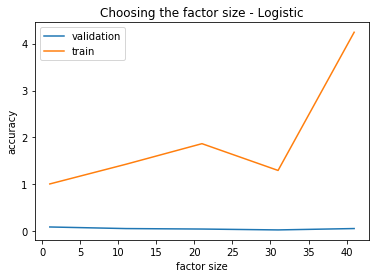

In [312]:
plt.plot(np.arange(1,50, 10),acc_val_fact_log, label = 'validation')
plt.plot(np.arange(1,50, 10),acc_train_fact_log, label = 'train')
plt.xlabel('factor size')
plt.ylabel('accuracy')
plt.title('Choosing the factor size - Logistic')
plt.legend()
plt.show()

In [316]:
acc_val_iter_log = np.zeros(5)
acc_train_iter_log = np.zeros(5)
i = 0
for it in iters:
    acc_val_it = []
    acc_train_it = []
    for cv_ind in range(cv):
        ind = [j for j in range(cv) if j != cv_ind]
        total_ind = np.concatenate([train_cv_ind[k] for k in ind] )
        X = track_playlist_data[total_ind]
        y = X_train.tracks[total_ind]
        X_test = track_playlist_data[train_cv_ind[cv_ind]]
        y_test = X_train.tracks[train_cv_ind[cv_ind]]
        model_mf = LogisticMatrixFactorization(factors = 5,iterations = it)
        # train the model on a sparse matrix of item/user/confidence weights
        model_mf.fit(X.T)
        acc_val_it.append(score(model_mf,X_test,y_test))
        acc_train_it.append(score(model_mf,X,y))
    acc_val_iter_log[i] = np.mean(acc_val_it)
    acc_train_iter_log[i] = np.mean(acc_train_it)
    print(acc_train_iter_log)
    print(acc_val_iter_log)
    i = i + 1    


[0.01191113 0.         0.         0.         0.        ]
[0.00896681 0.         0.         0.         0.        ]



[0.01191113 0.501606   0.         0.         0.        ]
[0.00896681 0.16715739 0.         0.         0.        ]



[0.01191113 0.501606   0.7134636  0.         0.        ]
[0.00896681 0.16715739 0.14079229 0.         0.        ]



[0.01191113 0.501606   0.7134636  0.79135439 0.        ]
[0.00896681 0.16715739 0.14079229 0.11844218 0.        ]



[0.01191113 0.501606   0.7134636  0.79135439 0.79028373]
[0.00896681 0.16715739 0.14079229 0.11844218 0.11589936]


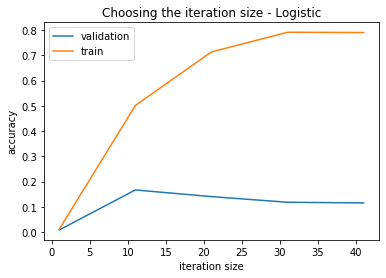

In [317]:
plt.plot(np.arange(1,50, 10),acc_val_iter_log, label = 'validation')
plt.plot(np.arange(1,50, 10),acc_train_iter_log, label = 'train')
plt.xlabel('iteration size')
plt.ylabel('accuracy')
plt.title('Choosing the iteration size - Logistic')
plt.legend()
plt.show()

In [332]:
# initialize a model
model_mf = LogisticMatrixFactorization(factors = 1, iterations = 50)

# train the model on a sparse matrix of item/user/confidence weights
model_mf.fit(track_playlist_data.T)
    
acc = 0
acc_ind = []
for ind in range(7473):
    playlistid = ind
    # recommend 10(default) tracks for a playlist
    playlist_track = track_playlist_data.T
    recommendations = model_mf.recommend(playlistid, playlist_track)
    playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
    playlist_true = [j for j in X_train.tracks[playlistid] if j is not None]
    acc_ind.append(intersect_rate(playlist_true,playlist_pred))

In [409]:
# initialize a model
model_mf = LogisticMatrixFactorization(factors = 1, iterations = 11)

# train the model on a sparse matrix of item/user/confidence weights
model_mf.fit(track_playlist_data.T)

acc = 0
acc_ind = []
for ind in range(len(X_test)):
    playlistid = ind
    # recommend 10(default) tracks for a playlist
    playlist_track = track_playlist_data_test.T
    recommendations = model_mf.recommend(playlistid, playlist_track)
    playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0]]
    playlist_true = [j for j in X_test.tracks[playlistid] if j is not None]
    acc_ind.append(intersect_rate(playlist_true,playlist_pred))
print('Overall test accuracy of LogMF: ', np.mean(acc_ind))


Overall test accuracy of LogMF:  0.22495049504950496


# -------End of Logistic MF

In [26]:
# show how the csr_matrix works
raw = [[0.0, 2.0, 1.5, 1.33333333, 1.25, 1.2, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 2.0, 1.5, 1.33333333, 1.25, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 2.0, 1.5, 1.33333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 2.0, 1.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.5, 1.33333333, 1.25, 1.2],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.5, 1.33333333, 1.25],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.5, 1.33333333],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 1.5],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0],
               [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
counts = csr_matrix(raw, dtype=np.float64)
print(counts)

  (0, 1)	2.0
  (0, 2)	1.5
  (0, 3)	1.33333333
  (0, 4)	1.25
  (0, 5)	1.2
  (1, 2)	2.0
  (1, 3)	1.5
  (1, 4)	1.33333333
  (1, 5)	1.25
  (2, 3)	2.0
  (2, 4)	1.5
  (2, 5)	1.33333333
  (3, 4)	2.0
  (3, 5)	1.5
  (4, 5)	2.0
  (6, 7)	2.0
  (6, 8)	1.5
  (6, 9)	1.33333333
  (6, 10)	1.25
  (6, 11)	1.2
  (7, 8)	2.0
  (7, 9)	1.5
  (7, 10)	1.33333333
  (7, 11)	1.25
  (8, 9)	2.0
  (8, 10)	1.5
  (8, 11)	1.33333333
  (9, 10)	2.0
  (9, 11)	1.5
  (10, 11)	2.0


In [57]:
#bayesian does not work very well in general

from implicit.bpr import BayesianPersonalizedRanking
acc_mean = np.zeros(5)
i = 0
for lr in [0.001,0.01,0.05,0.1,1]:
    # initialize a model
    model_bay = BayesianPersonalizedRanking(factors = 30, iterations = 50, learning_rate = lr)

    # train the model on a sparse matrix of item/user/confidence weights
    model_bay.fit(track_playlist_data.T)

    acc = 0
    acc_ind = []
    for ind in range(7473):
        playlistid = ind
        # recommend 10(default) tracks for a playlist
        playlist_track = track_playlist_data.tocsr()
        recommendations = model_bay.recommend(playlistid, playlist_track)
        playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
        playlist_true = [j for j in X_train.tracks[0] if j is not None]
        acc_ind.append(intersect_rate(playlist_true,playlist_pred))
    acc_mean[i] = np.mean(acc_ind)
    print(acc_mean[i])
    i = i + 1

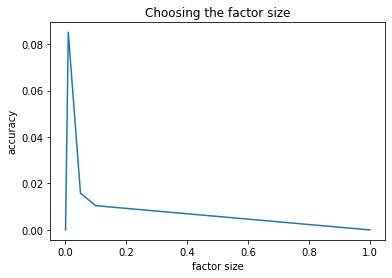

In [58]:
plt.plot([0.001,0.01,0.05,0.1,1],acc_mean)
plt.xlabel('learning rate')
plt.ylabel('accuracy')
plt.title('Choosing the learning rate')
plt.show()

In [64]:
 # initialize a model
model_bay = BayesianPersonalizedRanking(factors = 30,iterations = 100, learning_rate = 0.01,verify_negative_samples = True)

    # train the model on a sparse matrix of item/user/confidence weights
model_bay.fit(track_playlist_data.T)
acc = 0
acc_ind = []
for ind in range(7473):
    playlistid = ind
    # recommend 10(default) tracks for a playlist
    playlist_track = track_playlist_data.tocsr()
    recommendations = model_bay.recommend(playlistid, playlist_track)
    playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0] ]
    playlist_true = [j for j in X_train.tracks[0] if j is not None]
    acc_ind.append(intersect_rate(playlist_true,playlist_pred))

In [65]:
print('Overall accuracy of Bayesian Personalized Ranking: ', np.mean(acc_ind))

Overall accuracy of Bayesian Personalized Ranking:  0.026763013515321826


In [414]:
# initialize a model
model_bay = BayesianPersonalizedRanking(factors = 10,iterations = 20,learning_rate = 0.01, verify_negative_samples = True)

# train the model on a sparse matrix of item/user/confidence weights
model_bay.fit(track_playlist_data.T)

acc = 0
acc_ind = []
for ind in range(len(X_test)):
    playlistid = ind
    # recommend 10(default) tracks for a playlist
    playlist_track = track_playlist_data_test.T
    recommendations = model_bay.recommend(playlistid, playlist_track)
    playlist_pred = [tracks[i] for i in list(zip(*recommendations))[0]]
    playlist_true = [j for j in X_test.tracks[playlistid] if j is not None]
    acc_ind.append(intersect_rate(playlist_true,playlist_pred))
print('Overall test accuracy of LogMF: ', np.mean(acc_ind))


Overall test accuracy of LogMF:  0.044356435643564354
